In [2]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=485abc813931846a12646b4559c0bf6e5f5010c887a74c31e329a037625659d1
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [3]:
import python_speech_features as mfcc
from scipy.io.wavfile import read
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
!gdown --id 1gkUyLeI5ly1wBiXkdfGZDKQZLt3gcwCq

Downloading...
From: https://drive.google.com/uc?id=1gkUyLeI5ly1wBiXkdfGZDKQZLt3gcwCq
To: /content/LUMS_FALL2020_PROJECT_DATA.zip
802MB [00:09, 85.4MB/s]


In [ ]:
!unzip "LUMS_FALL2020_PROJECT_DATA"

In [7]:
#Feature extraction
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [8]:
#Function for reading data
def read_data(location, i):
  labels = []
  data = []
  for path in glob.glob(location + '/SPK*'):
    for files in glob.glob(path + '/*'):
      labels.append(path.split("/")[2].split("_")[i])
      sr, audio = read(files)
      features = get_MFCC(audio, sr)
      data.append(features)
  return np.array(labels), np.array(data)

In [9]:
#Function to add X0
def add_one(data):
  ones = np.ones((len(data), 1))
  temp = np.hstack((ones, data))
  return temp

**Reading speaker recognition data**

In [10]:
#Reading speaker recognition data
train_labels_sr, train_data_sr = read_data('Speaker_Recognition/Train', 0)
valid_labels_sr, valid_data_sr = read_data('Speaker_Recognition/Valid', 0)
test_labels_sr, test_data_sr = read_data('Speaker_Recognition/Test', 0)

In [11]:
#Adding X0 to speaker recognition data
if(train_data_sr.shape[1] == 13):
  train_data_sr = add_one(train_data_sr)
  valid_data_sr = add_one(valid_data_sr)
  test_data_sr = add_one(test_data_sr)
else:
  print("X0 already added")

**Reading gender recognition data**

In [12]:
#Reading gender recognition data
train_labels_gr, train_data_gr = read_data('Gender_Recognition/Train', 1)
valid_labels_gr, valid_data_gr = read_data('Gender_Recognition/Valid', 1)
test_labels_gr, test_data_gr = read_data('Gender_Recognition/Test', 1)

In [13]:
#Adding X0 to gender recognition data
if(train_data_gr.shape[1] == 13):
  train_data_gr = add_one(train_data_gr)
  valid_data_gr = add_one(valid_data_gr)
  test_data_gr = add_one(test_data_gr)
else:
  print("X0 already added")

# **Functions**

**Training functions**

In [14]:
#Softmax function
def softmax(z):
  s = []
  for i in range(len(z)):
    temp = np.exp(z[i])
    temp /= sum(np.exp(z))
    s.append(temp)
  return np.array(s)

In [15]:
#Cross Entropy Loss
def cross_entropy_loss(y_labels, predicted):
  temp = -np.dot(y_labels, np.log(predicted))
  return temp

In [16]:
#Hypothesis
def hypothesis(X, thetas):
  temp = np.dot(X, thetas)
  return(np.array(temp))

In [17]:
#Encode labels as 0 and 1
def one_hot_encode(data):
  classes = []

  for c in data:
    if(c not in classes):
      classes.append(c)

  new_labels = []
  for c in classes:
    temp = []
    for d in data:
      if (c == d):
        temp.append(1)
      else:
        temp.append(0)
    new_labels.append(np.array(temp))

  return np.array(new_labels), classes
  

In [18]:
#Gradient descent to learn values of thetas
def gradient_descent(X, Y, X_val, Y_val, classes, alpha, n_epoch):
  m = X.shape[0] #number of documents
  m2 = X_val.shape[0] #number of documents in validation set
  features = X.shape[1] #number of features
  total_classes = len(classes) #number of total classes

  thetas = np.zeros([total_classes, features]) #creating a matrix of thetas
  J = [] #List to store training loss
  Jval = [] #List to store validation loss

  for epoch in range(n_epoch):

    hypothesis_score = []
    h_score_val = []
    #Calculating hypothesis score for each class
    for c in range(total_classes):
      temp = hypothesis(X, thetas[c])
      temp_val = hypothesis(X_val, thetas[c])
      hypothesis_score.append(temp)
      h_score_val.append(temp_val)

    softmax_score = []
    softmax_score_val = []

    #Taking transpose of hypothesis score
    new_hscore = np.transpose(hypothesis_score)
    new_hscore_val = np.transpose(h_score_val)
    #Calculating softmax score for the hypothesis
    for s in range(m):
      softmax_score.append(softmax(np.array(new_hscore[s])))
    for s in range(m2):
      softmax_score_val.append(softmax(np.array(new_hscore_val[s])))

    #Tranposing softmax scores
    softmax_score1 = np.transpose(softmax_score)
    
    #Updating the values of thetas
    for n in range(total_classes):
      temp = softmax_score1[n] - Y[n]
      temp_sum = np.dot(np.transpose(X), temp)
      thetas[n] -= (alpha*temp_sum)/m

    #Taking transpose of true labels
    t_Y = np.transpose(Y)
    t_Yval = np.transpose(Y_val)
    
    #Calculating training loss
    loss = 0
    for n in range(m):
      loss += cross_entropy_loss(t_Y[n], softmax_score[n])
    
    #Caluclating validation loss
    val_loss = 0
    for n in range(m2):
      val_loss += cross_entropy_loss(t_Yval[n], softmax_score_val[n])

    #Appending the average training loss
    J.append(loss/m)
    #Appending the average validation loss
    Jval.append(val_loss/m2)

  return thetas, J, Jval


**Testing functions**

In [19]:
#Function to predict labels
def predict_labels(data, thetas, classes):
  hx = []
  for n in thetas:
    temp = hypothesis(data, n)
    hx.append(temp)
  
  t_hx = np.transpose(hx)

  softmax_score = []
  for n in t_hx:
    temp = softmax(n)
    softmax_score.append(temp) 
  
  predicted_labels = []
  for prob in softmax_score:
    predicted_labels.append(classes[np.argmax(prob)])

  return predicted_labels

**Evaluation functions**

In [20]:
#Function to calculate accuracy, classification report and confusion matrix
def evaluation(y_true, predicted):
  accuracy = accuracy_score(y_true, predicted)

  c_report = classification_report(y_true, predicted, output_dict=True, zero_division=0)
  macro_f1 = c_report['macro avg']['f1-score']
  macro_precision = c_report['macro avg']['precision']
  macro_recall = c_report['macro avg']['recall']

  print("Accuracy: %.3f" % (accuracy*100))
  print("Macro F1: %.3f" % macro_f1)
  print("Macro Precision: %.3f" % macro_precision)
  print("Macro Recall: %.3f" % macro_recall)


In [21]:
def confusionMatrix(y_true, predicted):
  data = confusion_matrix(y_true, predicted)
  con_mat = pd.DataFrame(data=data)
  return con_mat

# **Gender recognition**

**Training**

In [39]:
#Encoding the labels for different classes
labels_gr, classes_gr = one_hot_encode(train_labels_gr)
val_labels_gr, classes_val_gr = one_hot_encode(valid_labels_gr)

#Running the graident descent on training data

#Using 3 different values of alpha for validation
alpha_gr = [0.001, 0.01, 0.1, 0.3, 0.5]
epoch_gr = 300

theta_gr_total = []
J_gr_total = []
Jval_gr_total = []

#running gradient descent for different values of alpha
for i in range(len(alpha_gr)):
  thetas_gr, J_gr, Jval_gr = gradient_descent(train_data_gr, labels_gr, valid_data_gr, val_labels_gr, classes_gr, alpha_gr[i], epoch_gr)
  theta_gr_total.append(thetas_gr)
  J_gr_total.append(J_gr)
  Jval_gr_total.append(Jval_gr)

**Plots**

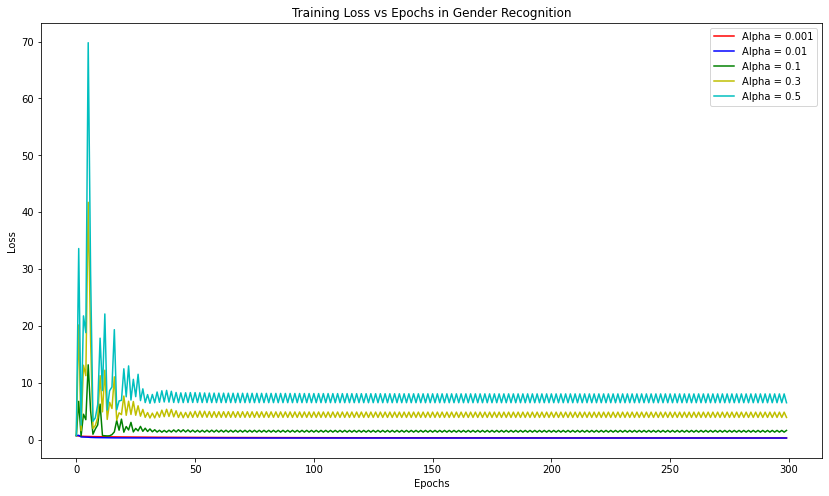

In [40]:
#Training Loss vs Epochs for different values of alpha in Gender Recognition

epoch_list_gr = list(range(0, 300))
plt.figure(figsize = (14, 8))
plt.plot(epoch_list_gr, J_gr_total[0], 'r', label = "Alpha = 0.001")
plt.plot(epoch_list_gr, J_gr_total[1], 'b', label = "Alpha = 0.01")
plt.plot(epoch_list_gr, J_gr_total[2], 'g', label = "Alpha = 0.1")
plt.plot(epoch_list_gr, J_gr_total[3], 'y', label = "Alpha = 0.3")
plt.plot(epoch_list_gr, J_gr_total[4], 'c', label = "Alpha = 0.5")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training Loss vs Epochs in Gender Recognition')
plt.legend()
plt.show()

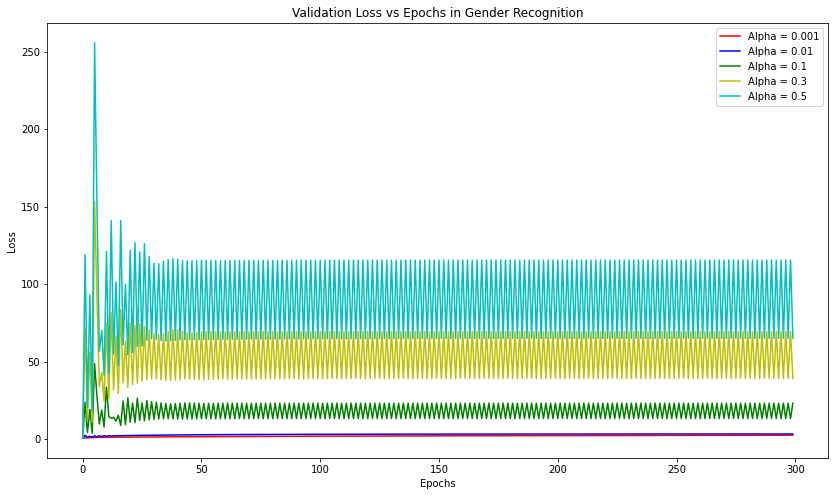

In [24]:
#Validation Loss vs Epochs for different values of alpha in Gender Recognition

epoch_list_gr = list(range(0, 300))
plt.figure(figsize = (14, 8))
plt.plot(epoch_list_gr, Jval_gr_total[0], 'r', label = "Alpha = 0.001")
plt.plot(epoch_list_gr, Jval_gr_total[1], 'b', label = "Alpha = 0.01")
plt.plot(epoch_list_gr, Jval_gr_total[2], 'g', label = "Alpha = 0.1")
plt.plot(epoch_list_gr, Jval_gr_total[3], 'y', label = "Alpha = 0.3")
plt.plot(epoch_list_gr, Jval_gr_total[4], 'c', label = "Alpha = 0.5")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Validation Loss vs Epochs in Gender Recognition')
plt.legend()
plt.show()

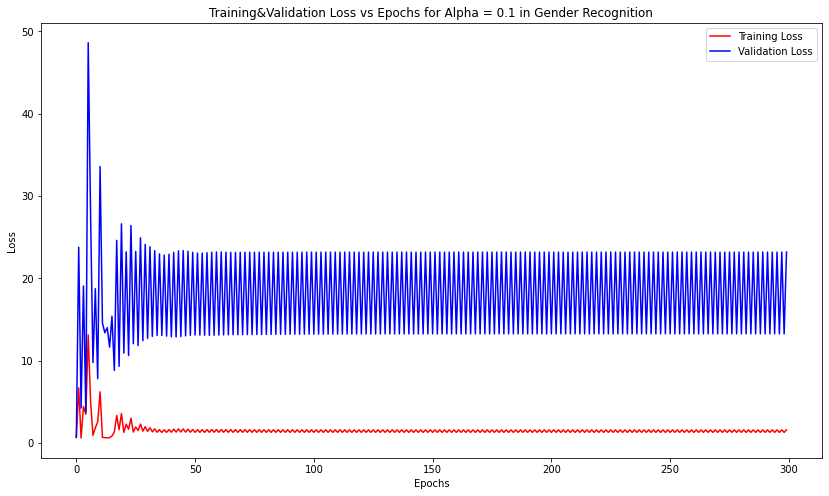

In [25]:
#Training and Validation Loss vs Epochs for Alpha = 0.1 in Gender Recognition
#Choosing alpha=0.1 since 0.001 and 0.01 are not diverging initially and may be overfitting the training data. 0.3 and 0.5 on the other hand have a greater loss.

epoch_list_gr = list(range(0, 300))
plt.figure(figsize = (14, 8))
plt.plot(epoch_list_gr, J_gr_total[2], 'r', label = "Training Loss")
plt.plot(epoch_list_gr, Jval_gr_total[2], 'b', label = "Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training&Validation Loss vs Epochs for Alpha = 0.1 in Gender Recognition')
plt.legend()
plt.show()

**Testing**

In [26]:
#Predicting labels for gender recognition
predicted_labels_gr = predict_labels(test_data_gr, theta_gr_total[2], classes_gr)

**Evaluation**

In [27]:
#Evaluating the gender recognition classifier
evaluation(test_labels_gr, predicted_labels_gr)

Accuracy: 84.706
Macro F1: 0.816
Macro Precision: 0.795
Macro Recall: 0.874


In [28]:
#Confusion for gender recognition
matrix = confusionMatrix(test_labels_gr, predicted_labels_gr)
matrix

,0,1
0,37,3
1,23,107


## **Speaker Recognition**

**Training**

In [29]:
#May take up to 15 minutes to run

#Encoding the labels for different classes
labels_sr, classes_sr = one_hot_encode(train_labels_sr)
val_labels_sr, classes_val_sr = one_hot_encode(valid_labels_sr)

#Running the graident descent on training data

#Using 3 different values of alpha for validation
alpha_sr = [0.01, 0.1, 0.3]
epoch_sr = 50

theta_sr_total = []
J_sr_total = []
Jval_sr_total = []

for i in range(3):
  thetas_sr, J_sr, Jval_sr = gradient_descent(train_data_sr, labels_sr, valid_data_sr, val_labels_sr, classes_sr, alpha_sr[i], epoch_sr)
  theta_sr_total.append(thetas_sr)
  J_sr_total.append(J_sr)
  Jval_sr_total.append(Jval_sr)

**Plots**

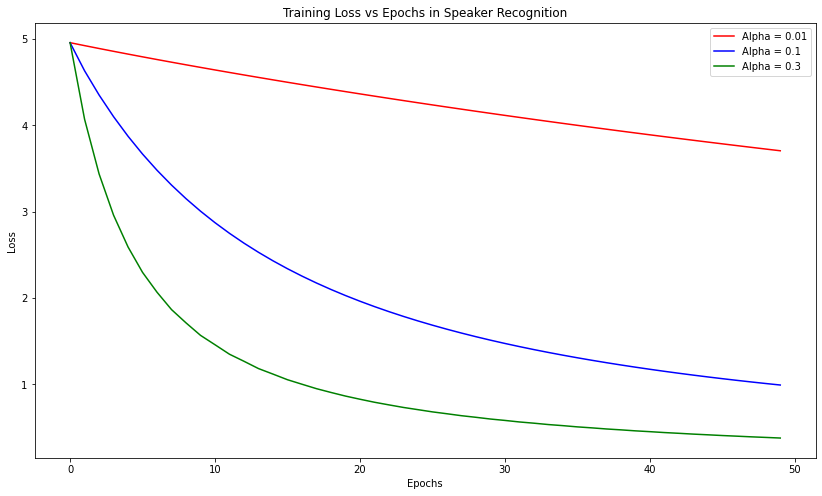

In [30]:
#Training Loss vs Epochs for different values of alpha in Speaker Recognition

epoch_list_sr = list(range(0, 50))
plt.figure(figsize = (14, 8))
plt.plot(epoch_list_sr, J_sr_total[0], 'r', label = "Alpha = 0.01")
plt.plot(epoch_list_sr, J_sr_total[1], 'b', label = "Alpha = 0.1")
plt.plot(epoch_list_sr, J_sr_total[2], 'g', label = "Alpha = 0.3")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training Loss vs Epochs in Speaker Recognition')
plt.legend()
plt.show()

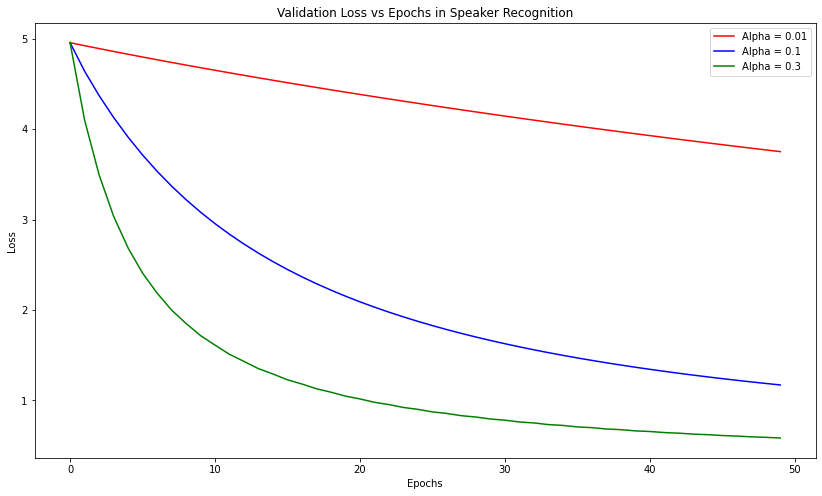

In [31]:
#Validation Loss vs Epochs for different values of alpha in Speaker Recognition

plt.figure(figsize = (14, 8))
plt.plot(epoch_list_sr, Jval_sr_total[0], 'r', label = "Alpha = 0.01")
plt.plot(epoch_list_sr, Jval_sr_total[1], 'b', label = "Alpha = 0.1")
plt.plot(epoch_list_sr, Jval_sr_total[2], 'g', label = "Alpha = 0.3")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Validation Loss vs Epochs in Speaker Recognition')
plt.legend()
plt.show()

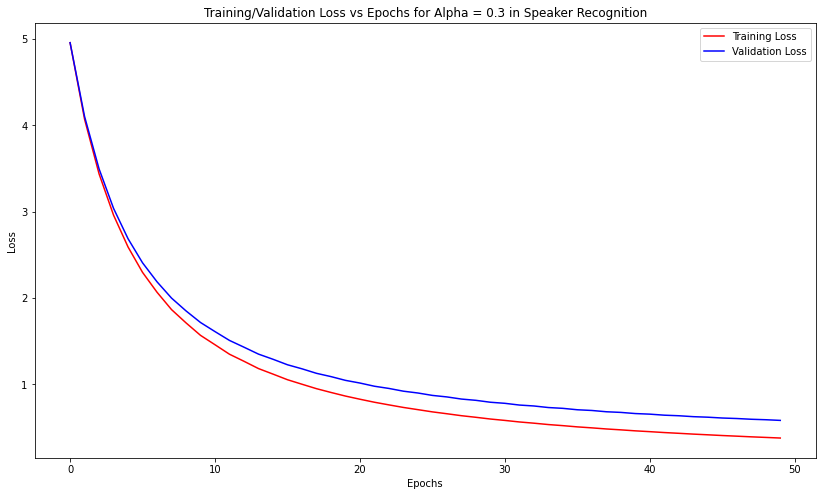

In [32]:
#Training and Validation Loss vs Epochs for Alpha = 0.3 in Speaker Recognition
#Choosing alpha=0.3 since it converges faster.

plt.figure(figsize = (14, 8))
plt.plot(epoch_list_sr, J_sr_total[2], 'r', label = "Training Loss")
plt.plot(epoch_list_sr, Jval_sr_total[2], 'b', label = "Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training/Validation Loss vs Epochs for Alpha = 0.3 in Speaker Recognition')
plt.legend()
plt.show()

**Testing**

In [33]:
#Predicting labels for speaker recognition
predicted_labels_sr = predict_labels(test_data_sr, theta_sr_total[2], classes_sr)

**Evaluation**

In [34]:
#Evaluating the speaker recognition classifier
evaluation(test_labels_sr, predicted_labels_sr)

Accuracy: 94.718
Macro F1: 0.942
Macro Precision: 0.954
Macro Recall: 0.947


In [35]:
#Confusion for speaker recognition
matrix = confusionMatrix(test_labels_sr, predicted_labels_sr)
matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
